In [2]:
from google.colab import drive
import shutil, zipfile, os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Mount and extract
drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/DATASET.zip", "/content/")
with zipfile.ZipFile("DATASET.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
os.listdir("dataset")


Mounted at /content/drive


['DATASET']

In [3]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X, y = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            try:
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                X.append(np.array(img))
                y.append(class_map[class_name])
            except:
                continue
    return np.array(X), np.array(y), class_map

X, y, class_map = load_images_from_folder("dataset/DATASET")
X = X / 255.0

In [4]:
class_names = list(class_map.keys())
print("Detected Classes:")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

Detected Classes:
0: BLAZERS
1: DRESSES
2: FOOTWEAR
3: HOODIES
4: PANTS
5: SHIRTS
6: SHORTS
7: SKIRTS
8: SUITS
9: SWEARSHIRTS


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)


In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [8]:
from tensorflow.keras import layers, models, Input

# Input shape
input_shape = (224, 224, 3)
num_classes = len(class_map)  # Replace class_map with your actual dictionary

inputs = Input(shape=input_shape)

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.25)(x)

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.3)(x)

# Block 3 (with skip connection and matching filters)
shortcut = x  # shape: (56, 56, 128)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Match shortcut to 256 channels
shortcut = layers.Conv2D(256, (1, 1), padding='same')(shortcut)
shortcut = layers.BatchNormalization()(shortcut)

# Add skip connection
x = layers.Add()([x, shortcut])

x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.4)(x)
# Block 4
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.5)(x)

# Classification Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Build model
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     33,024 │ dropout_1[0][0] 

 Total params: 5,788,490 (22.08 MB)

 Trainable params: 5,781,066 (22.05 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
import tensorflow as tf
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=25),
    validation_data=(X_val, y_val),
    epochs=70,
    class_weight=class_weights,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1611 - loss: 3.3345 - val_accuracy: 0.1500 - val_loss: 2.3044
Epoch 2/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 397ms/step - accuracy: 0.3263 - loss: 2.5936 - val_accuracy: 0.1000 - val_loss: 2.3561
Epoch 3/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 381ms/step - accuracy: 0.3173 - loss: 2.5711 - val_accuracy: 0.1000 - val_loss: 2.4361
Epoch 4/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - accuracy: 0.3315 - loss: 2.4758 - val_accuracy: 0.1000 - val_loss: 2.5862
Epoch 5/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.3628 - loss: 2.2700 - val_accuracy: 0.1000 - val_loss: 2.7838
Epoch 6/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.3309 - loss: 2.4114 - val_accuracy: 0.2300 - val_loss: 3.2534
Epoch 7/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step - accuracy: 0.4092 - loss: 2.1332 - val_accuracy: 0.2300 - val_loss: 4.9666
Epoch 8/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.4068 - loss: 2.2448 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
👕 Predicted Fashion Item: SHORTS


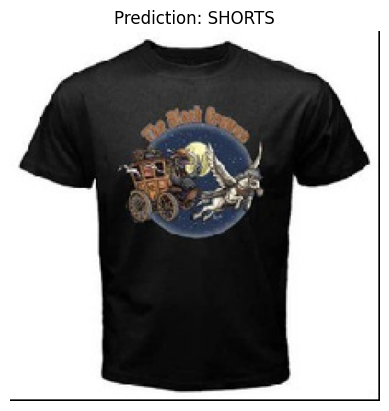

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image



def predict_fashion(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # batch of one

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Output result
    print(f"👕 Predicted Fashion Item: {predicted_class}")
    return predicted_class

# Function to visualize prediction
def predict_and_show(img_path):
    pred = predict_fashion(img_path)

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Prediction: {pred}")
    plt.axis('off')
    plt.show()

# Example usage (update with your image path)
predict_and_show(img_path='/content/dataset/DATASET/SHIRTS/10.jpg')


In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 814ms/step - accuracy: 0.6051 - loss: 1.4486
Test Accuracy: 0.6400


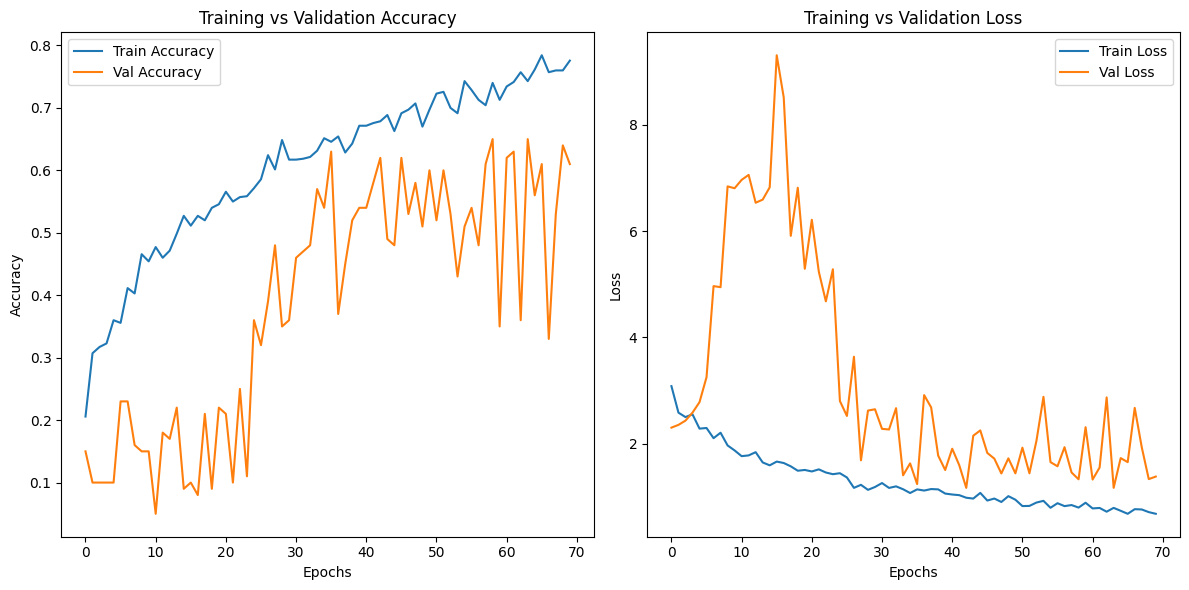

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step

Classification Report:

              precision    recall  f1-score   support

     BLAZERS       0.69      0.90      0.78        20
     DRESSES       0.62      0.40      0.48        20
    FOOTWEAR       1.00      0.90      0.95        30
     HOODIES       0.18      0.30      0.22        10
       PANTS       0.65      0.75      0.70        20
      SHIRTS       0.64      0.45      0.53        20
      SHORTS       0.40      0.85      0.54        20
      SKIRTS       0.70      0.70      0.70        20
       SUITS       1.00      0.55      0.71        20
 SWEARSHIRTS       1.00      0.30      0.46        20

    accuracy                           0.64       200
   macro avg       0.69      0.61      0.61       200
weighted avg       0.73      0.64      0.64       200



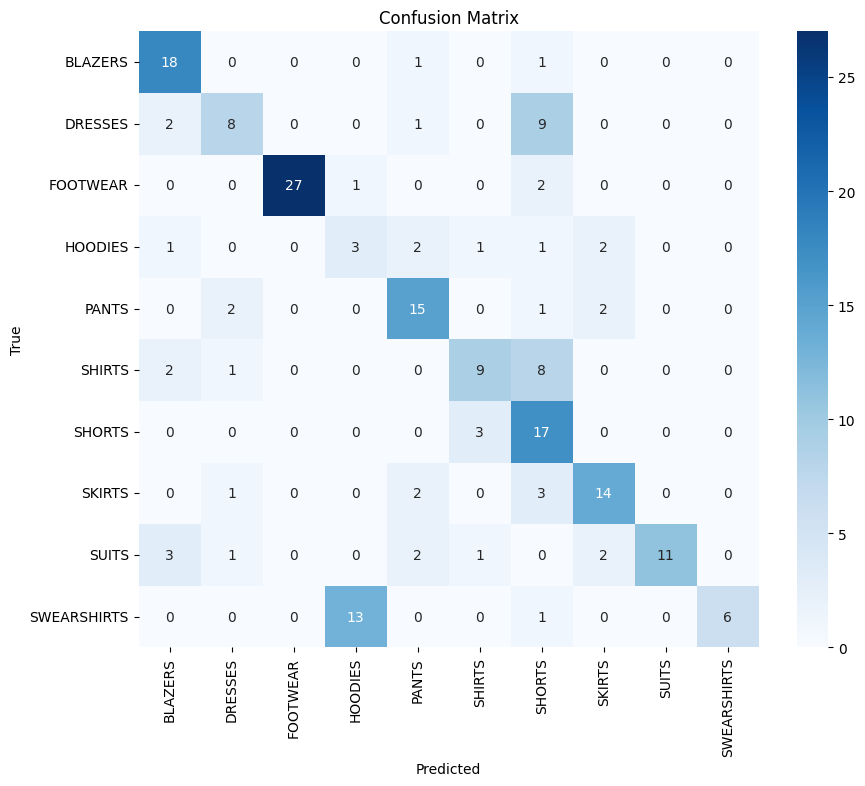

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict labels on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

Classification Report:
              precision    recall  f1-score   support

     BLAZERS       0.69      0.90      0.78        20
     DRESSES       0.62      0.40      0.48        20
    FOOTWEAR       1.00      0.90      0.95        30
     HOODIES       0.18      0.30      0.22        10
       PANTS       0.65      0.75      0.70        20
      SHIRTS       0.64      0.45      0.53        20
      SHORTS       0.40      0.85      0.54        20
      SKIRTS       0.70      0.70      0.70        20
       SUITS       1.00      0.55      0.71        20
 SWEARSHIRTS       1.00      0.30      0.46        20

    accuracy                           0.64       200
   macro avg       0.69      0.61      0.61       200
weighted avg       0.73      0.64      0.64       200



In [16]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert probabilities to predicted class labels
train_preds_class = np.argmax(train_preds, axis=1)
val_preds_class = np.argmax(val_preds, axis=1)
test_preds_class = np.argmax(test_preds, axis=1)

# True labels (assuming already integers)
y_train_class = y_train
y_val_class = y_val
y_test_class = y_test

# AUC Scores
train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_preds, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr')

# Accuracy
train_accuracy = np.mean(train_preds_class == y_train_class)
val_accuracy = np.mean(val_preds_class == y_val_class)
test_accuracy = np.mean(test_preds_class == y_test_class)

# Loss
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Precision, Recall, F1-Score (Weighted & Macro)
precision_weighted = precision_score(y_test_class, test_preds_class, average='weighted')
recall_weighted = recall_score(y_test_class, test_preds_class, average='weighted')
f1_weighted = f1_score(y_test_class, test_preds_class, average='weighted')

precision_macro = precision_score(y_test_class, test_preds_class, average='macro')
recall_macro = recall_score(y_test_class, test_preds_class, average='macro')
f1_macro = f1_score(y_test_class, test_preds_class, average='macro')

# Sensitivity = Recall (Weighted)
sensitivity = recall_weighted

# Specificity (approximate for multiclass): TN / (TN + FP) averaged
conf_matrix = confusion_matrix(y_test_class, test_preds_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = np.mean(TN / (TN + FP))

# Classification Miss Rate
miss_rate = 1 - sensitivity

# Output all metrics
print(f"🔹 AUC - Train: {train_auc:.4f}, Validation: {val_auc:.4f}, Test: {test_auc:.4f}")
print(f"🔹 Accuracy - Train: {train_accuracy:.4f}, Validation: {val_accuracy:.4f}, Test: {test_accuracy:.4f}")
print(f"🔹 Loss - Train: {train_loss:.4f}, Validation: {val_loss:.4f}, Test: {test_loss:.4f}")
print(f"🔹 Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}")
print(f"🔹 Recall (Sensitivity) (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}")
print(f"🔹 F1-Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}")
print(f"🔹 Specificity (approx): {specificity:.4f}")
print(f"🔹 Classification Miss Rate: {miss_rate:.4f}")
print("\n🔹 Confusion Matrix:\n", conf_matrix)
print("\n🔹 Classification Report:\n", classification_report(y_test_class, test_preds_class))


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
🔹 AUC - Train: 0.9770, Validation: 0.9265, Test: 0.9254
🔹 Accuracy - Train: 0.7243, Validation: 0.6100, Test: 0.6400
🔹 Loss - Train: 0.7812, Validation: 1.3836, Test: 1.3483
🔹 Precision (Weighted): 0.7286, (Macro): 0.6875
🔹 Recall (Sensitivity) (Weighted): 0.6400, (Macro): 0.6100
🔹 F1-Score (Weighted): 0.6438, (Macro): 0.6075
🔹 Specificity (approx): 0.9604
🔹 Classification Miss Rate: 0.3600

🔹 Confusion Matrix:
 [[18  0  0  0  1  0  1  0  0  0]
 [ 2  8  0  0  1  0  9  0  0  0]
 [ 0  0 27  1  0  0  2  0  0  0]
 [ 1  0  0  3  2  1  1  2  0  0]
 [ 0  2  0  0 15  0  1  2  0  0]
 [ 2  1  0  0  0  9  8  0  0  0]
 [ 0  0  0  0  0  3 17  0  0  0]
 [ 0  1  0  0  2  0  3 14  0  0]
 [ 3  1  0  0  2  1  0  2 11  0]
 [ 0  0  0 13  0  0  1  0  0  6]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.90      0.78        

In [17]:
from sklearn.metrics import (
    confusion_matrix, fbeta_score, precision_score, recall_score, f1_score
)
import numpy as np

# Predict classes
test_preds = model.predict(X_test)
test_preds_class = np.argmax(test_preds, axis=1)
y_true = y_test  # assumed to be integer-encoded

# Confusion Matrix
cm = confusion_matrix(y_true, test_preds_class)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Small value to prevent divide-by-zero
eps = 1e-10

# F2-Score (beta=2)
f2_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=2)

# Fβ-Score for general beta (set your desired beta)
beta = 0.5
f_beta_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=beta)

# Positive Predictive Value (Precision)
ppv = precision_score(y_true, test_preds_class, average='weighted')

# Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN + eps))

# False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN + eps))

# False Negative Rate (FNR)
fnr = np.mean(FN / (FN + TP + eps))

# Likelihood Ratios
sensitivity = recall_score(y_true, test_preds_class, average='weighted')
specificity = np.mean(TN / (TN + FP + eps))

lr_positive = sensitivity / (1 - specificity + eps)
lr_negative = (1 - sensitivity) / (specificity + eps)

# Fowlkes–Mallows Index (FMI)
precision_macro = precision_score(y_true, test_preds_class, average='macro')
recall_macro = recall_score(y_true, test_preds_class, average='macro')
fmi = np.sqrt(precision_macro * recall_macro)

# Print Results
print(f"🔹 F2-Score (Weighted): {f2_score_weighted:.4f}")
print(f"🔹 F{beta}-Score (Weighted): {f_beta_score_weighted:.4f}")
print(f"🔹 Positive Predictive Value (PPV): {ppv:.4f}")
print(f"🔹 Negative Predictive Value (NPV): {npv:.4f}")
print(f"🔹 False Positive Rate (FPR): {fpr:.4f}")
print(f"🔹 False Negative Rate (FNR): {fnr:.4f}")
print(f"🔹 Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
print(f"🔹 Likelihood Ratio Negative (LR−): {lr_negative:.4f}")
print(f"🔹 Fowlkes–Mallows Index (FMI): {fmi:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
🔹 F2-Score (Weighted): 0.6339
🔹 F0.5-Score (Weighted): 0.6791
🔹 Positive Predictive Value (PPV): 0.7286
🔹 Negative Predictive Value (NPV): 0.9609
🔹 False Positive Rate (FPR): 0.0396
🔹 False Negative Rate (FNR): 0.3900
🔹 Likelihood Ratio Positive (LR+): 16.1654
🔹 Likelihood Ratio Negative (LR−): 0.3748
🔹 Fowlkes–Mallows Index (FMI): 0.6476


In [18]:
import tensorflow as tf

# Saving the model
model.save('/content/drive/My Drive/Collab Notebooks/fashion_product.h5')


In [19]:
!ls "/content/drive/My Drive/Collab Notebooks"

fashion_product.h5  fashion_product_mobilenet.h5


In [20]:
!pip install gradio
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model('/content/drive/My Drive/Collab Notebooks/fashion_product.h5')

# Define class names (same as in your dataset)
class_names = ['Blazers', 'Dresses', 'Footwear', 'Hoodies', 'Pants', 'Shirts', 'Shorts', 'Skirts', 'Suits', 'Sweatshirts']

# Helper function to preprocess the image and make predictions
def predict_fashion(img):
    # Preprocess image
    img = img.resize((224, 224))  # Resize to match the model's input size
    img_array = np.array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    return predicted_class

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_fashion,  # Function to call for prediction
    inputs=gr.Image(type="pil"),  # Upload image as PIL object
    outputs=gr.Textbox(),  # Output the prediction as text
    live=True,  # Make it live for real-time prediction (optional)
    title="Fashion Item Classifier",  # Webpage title
    description="Upload a fashion item image to predict its class",  # Description of the app
)

# Launch the app
iface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.4 MB/s eta 0:00:00


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4786f8cb800757da5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
